<a href="https://colab.research.google.com/github/hirossk/ishs/blob/main/%E7%9F%B3%E7%8B%A9%E5%B8%82%E9%98%B2%E7%81%BD%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 今回の授業

今日の授業の到達点は次のように石狩市で想定される災害を「動的に見て（分析して）みる」です。

皆さんが普段使うスマホの地図。これに国勢調査などの「統計」や、災害リスクを示す「ハザードマップ」を重ね合わせると、ただの地図が強力な分析ツールに変わります。

今まで見えなかった「まちの弱点」、例えば「高齢者が多く住む浸水危険エリア」などが浮かび上がってくるのです。

今日は、このデータサイエンス（データ分析）によって、自分たちの地域の防災を考える方法を学びます。

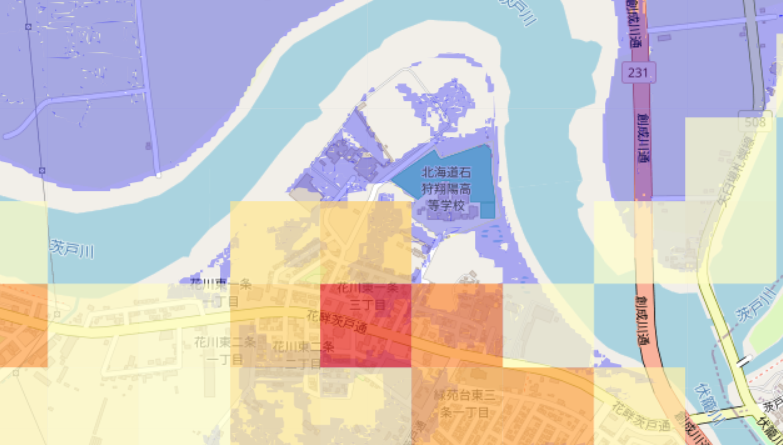

# 地域の分析に使える統計データ

人口メッシュ

https://www.e-stat.go.jp/gis


https://www.meti.go.jp/statistics/tyo/syougyo/mesh/2014/meshsearch/6441.html

被害を想定するためにどのような場所にどのような人が（住民）が居住しているのか「国勢調査」のメッシュデータを使うことができます。

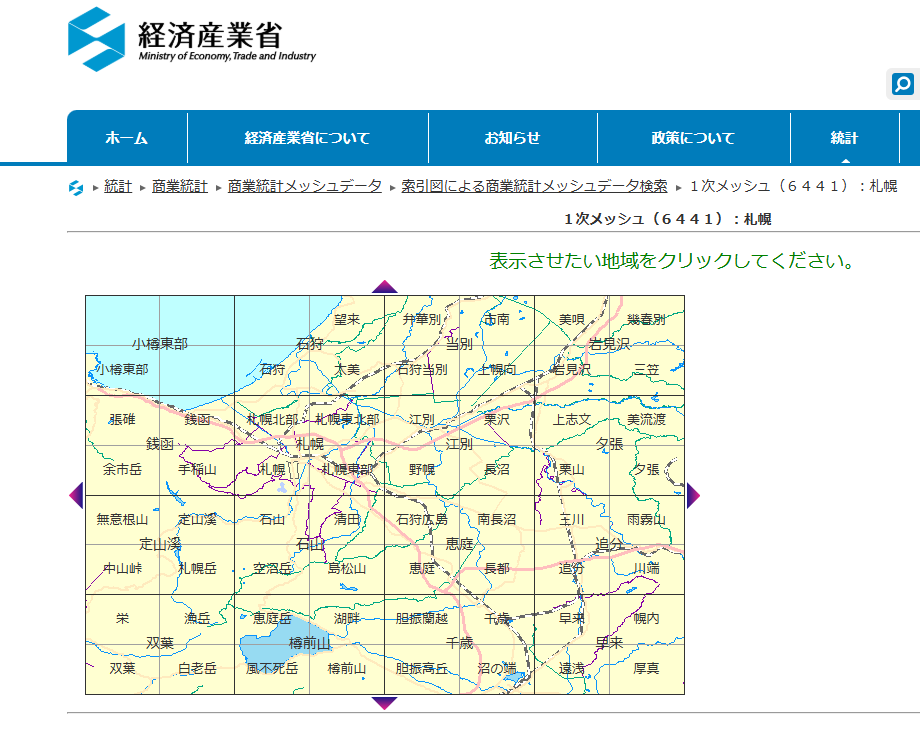

## 人口のメッシュデータを地図に表示してみましょう。

### メッシュの種類

国勢調査で使う「地域メッシュ」とは、日本全国を同じ大きさの四角い網の目で区切ったものです。市区町村のように形が変動しないため、どの地域でも同じ基準で比較できるのが利点です。

基準となる「3次メッシュ」は約1km四方で、皆さんが通う学校とその周辺一帯ほどの広さです。

これを縦横に4等分したものが「4次メッシュ」（約500m四方）、さらに4等分したものが「5次メッシュ」（約250m四方）で、大きな校舎一つ分ほどの大きさになります。

この細かい網の目ごとに人口などを集計し、地域の詳細な特徴を把握することで、防災マップの作成などにも活用されています。

#### 分析のための準備作業をします。

In [ ]:
# --- 必要なライブラリのインストール（Colab） ---
!pip install geopandas shapely folium -q

In [ ]:
# --- ライブラリのインポート ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from branca.colormap import linear

4次メッシュデータ（500m）の処理用コード

In [ ]:
# 500mメッシュ用コード

# --- 500mメッシュコード → ポリゴン（ズレ修正済み）---
def meshcode_to_bbox_500m(code_9digit):
    code_str = str(code_9digit).zfill(9)
   # --- ステップ1: 3次メッシュ（1km）の基準点を計算 ---
    p = int(code_str[:8])
    lat_start = (p // 1000000) / 1.5
    lon_start = ((p % 1000000) // 10000) + 100

    lat_start += ((p % 10000) // 1000) * (1.0 / 8) / 1.5
    lon_start += ((p % 1000) // 100) * (1.0 / 8)

    lat_start += ((p % 100) // 10) * (1.0 / 80) / 1.5
    lon_start += (p % 10) * (1.0 / 80)

    # --- ステップ2: 4次メッシュ（500m）のオフセットを「足し合わせる」---
    code_4th = int(code_str[8])
    y_div_4th = (code_4th - 1) // 2
    x_div_4th = (code_4th - 1) % 2

    lat_start += y_div_4th * (1.0 / 240)
    lon_start += x_div_4th * (1.0 / 160)

    lat_height = 1.0 / 240
    lon_width = 1.0 / 160

    return box(lon_start, lat_start, lon_start + lon_width, lat_start + lat_height)

5次メッシュデータ（250m）の処理用コード

In [ ]:

# --- 250mメッシュコード → ポリゴン（ズレ修正済み）---
def meshcode_to_bbox_250m(code_10digit):
    """
    10桁の5次メッシュコード（250mメッシュ）から、その領域を示すポリゴンを生成します。
    """
    code_str = str(code_10digit).zfill(10)

    # --- ステップ1: 3次メッシュ（1km）の基準点を計算 ---
    p = int(code_str[:8])
    lat_start = (p // 1000000) / 1.5
    lon_start = ((p % 1000000) // 10000) + 100

    lat_start += ((p % 10000) // 1000) * (1.0 / 8) / 1.5
    lon_start += ((p % 1000) // 100) * (1.0 / 8)

    lat_start += ((p % 100) // 10) * (1.0 / 80) / 1.5
    lon_start += (p % 10) * (1.0 / 80)

    # --- ステップ2: 4次メッシュ（500m）のオフセットを「足し合わせる」---
    code_4th = int(code_str[8])
    y_div_4th = (code_4th - 1) // 2
    x_div_4th = (code_4th - 1) % 2

    lat_start += y_div_4th * (1.0 / 240)
    lon_start += x_div_4th * (1.0 / 160)

    # --- ステップ3: 5次メッシュ（250m）のオフセットを「さらに足し合わせる」---
    code_5th = int(code_str[9])
    y_div_5th = (code_5th - 1) // 2
    x_div_5th = (code_5th - 1) % 2

    lat_start += y_div_5th * (1.0 / 480) # 500mメッシュの緯度方向の1/2
    lon_start += x_div_5th * (1.0 / 320) # 500mメッシュの経度方向の1/2

    # --- ステップ4: 250mメッシュの大きさを定義してポリゴンを作成 ---
    lat_height = 1.0 / 480
    lon_width = 1.0 / 320

    return box(lon_start, lat_start, lon_start + lon_width, lat_start + lat_height)

#### 地図上に4次メッシュの人口（総数）を表示

In [ ]:
target= '人口（総数）'

# --- CSV読み込み（1行目は列名ではない） ---
csv_path = '/content/mesh500.csv'

try:
    df = pd.read_csv(csv_path, skiprows=1, encoding='utf-8', dtype={'KEY_CODE': str})
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, skiprows=1, encoding='shift_jis', dtype={'KEY_CODE': str})

# --- 列名の前後の全角スペースを削除 ---
df.columns = [col.strip().replace('\u3000', '') for col in df.columns]
print(df.columns)

df.rename(columns={df.columns[0]: 'KEY_CODE'}, inplace=True)
df['KEY_CODE_9digit'] = df['KEY_CODE']
df[target] = pd.to_numeric(df[target], errors='coerce')
df.dropna(subset=['KEY_CODE_9digit', target], inplace=True)

# --- ポリゴン化 ---
df['geometry'] = df['KEY_CODE_9digit'].apply(meshcode_to_bbox_500m)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

# --- 地図作成 ---
center = [43.17, 141.31]
m = folium.Map(location=center, zoom_start=12)

# --- カラーマップ設定 ---
colormap = linear.YlOrRd_09.scale(
    gdf[target].min(),
    gdf[target].max()
)
colormap.caption = target
colormap.add_to(m)

# --- スタイル関数（ボーダーなし） ---
def style_function(feature):
    pop = feature['properties'][target]
    return {
        'fillColor': colormap(pop),
        'color': 'none',
        'weight': 0,
        'fillOpacity': 0.7
    }

# --- GeoJson描画 ---
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["KEY_CODE_9digit", target],
        aliases=["メッシュコード:", "人口:"],
        localize=True
    ),
    name='人口メッシュ (500m)'
).add_to(m)

# --- レイヤーコントロール ---
folium.LayerControl().add_to(m)

# --- 地図を保存 ---
m.save('/content/ishikari_population_map.html')
m


#### 地図上に5次メッシュの人口（総数）を表示

In [ ]:
# 250mメッシュ用コード

target= '人口（総数）'

# --- CSV読み込み（1行目は列名ではない） ---
csv_path = '/content/mesh250.csv'

try:
    df = pd.read_csv(csv_path, skiprows=1, encoding='utf-8', dtype={'KEY_CODE': str})
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, skiprows=1, encoding='shift_jis', dtype={'KEY_CODE': str})

# --- 列名の前後の全角スペースを削除 ---
df.columns = [col.strip().replace('\u3000', '') for col in df.columns]
print(df.columns)

df.rename(columns={df.columns[0]: 'KEY_CODE'}, inplace=True)
df['KEY_CODE_10digit'] = df['KEY_CODE']
df[target] = pd.to_numeric(df[target], errors='coerce')
df.dropna(subset=['KEY_CODE_10digit', target], inplace=True)

# --- ポリゴン化 ---
df['geometry'] = df['KEY_CODE_10digit'].apply(meshcode_to_bbox_250m)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

# --- 石狩市周辺をフィルタリング ---
bbox = box(141.25, 43.13, 141.50, 43.4)
gdf_filtered = gdf[gdf.intersects(bbox)].copy()

# --- 地図作成 ---
center = [43.17, 141.31]
m = folium.Map(location=center, zoom_start=12)

# --- カラーマップ設定 ---
colormap = linear.YlOrRd_09.scale(
    gdf[target].min(),
    gdf[target].max()
)
colormap.caption = target
colormap.add_to(m)

# --- スタイル関数（ボーダーなし） ---
def style_function(feature):
    pop = feature['properties'][target]
    return {
        'fillColor': colormap(pop),
        'color': 'none',
        'weight': 0,
        'fillOpacity': 0.7
    }

# --- GeoJson描画 ---
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["KEY_CODE_10digit", target],
        aliases=["メッシュコード:", "人口:"],
        localize=True
    ),
    name='人口メッシュ (250m)'
).add_to(m)

# --- レイヤーコントロール ---
folium.LayerControl().add_to(m)

# --- 地図を保存 ---
m.save('/content/ishikari_population_map.html')
m


## 石狩市のポリゴン（地区限定）で抽出

石狩市のみの国勢調査のメッシュデータを抽出します。
こうすることでデータが軽くなります。


石狩市のポリゴンデータのダウンロードはこちからから

https://nlftp.mlit.go.jp/ksj/

エリア北海道でダウンロードします。

ファイル名：
N03-20240101_01_GML.zip

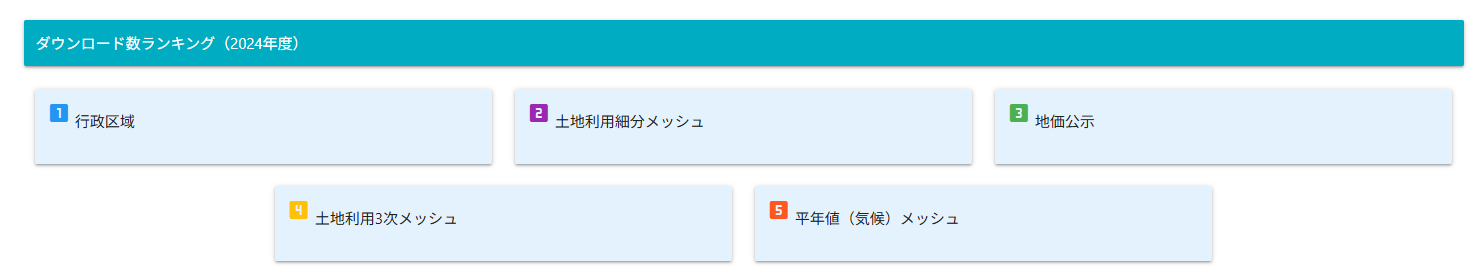

ファイルをアップロードしてから次のコードを実行することで石狩市の教会データが取得できます。


In [ ]:
import geopandas as gpd
import os

# --- 1. ファイルパスの定義 ---
# 入力ファイル（北海道全体の行政区域データ）
input_geojson_path = 'N03-20240101_01.geojson'

# 出力ファイル（抽出後の石狩市のデータ）
output_geojson_path = 'ishikari_city_boundary.geojson'

print(f"入力ファイル: {input_geojson_path}")
print(f"出力ファイル: {output_geojson_path}")


# --- 2. 北海道全体のデータを読み込み ---
try:
    print("\n北海道全体のデータを読み込んでいます...")
    gdf_hokkaido = gpd.read_file(input_geojson_path)
    print("読み込みが完了しました。")
    # 参考：データに含まれる列名を表示
    print(f"データに含まれる列名: {gdf_hokkaido.columns.tolist()}")
except Exception as e:
    print(f"\nエラー: ファイルの読み込みに失敗しました。'{input_geojson_path}'がアップロードされているか確認してください。")
    print(f"詳細: {e}")
    # エラーが発生した場合はここで処理を中断
    exit()


# --- 3. 石狩市のデータを抽出 ---
# 国土数値情報の行政区域データでは、市区町村名は 'N03_004' という列に格納されています。
city_name_column = 'N03_004'
target_city_name = '石狩市'

print(f"\n'{city_name_column}' 列から '{target_city_name}' のデータを抽出します...")

# 'N03_004' 列の値が '石狩市' の行だけをフィルタリング
gdf_ishikari = gdf_hokkaido[gdf_hokkaido[city_name_column] == target_city_name].copy()


# --- 4. 抽出結果の確認と保存 ---
if not gdf_ishikari.empty:
    print(f"'{target_city_name}' のデータが見つかりました。")

    # 抽出したデータを新しいGeoJSONファイルとして保存
    # 日本語が含まれるため、エンコーディングを'utf-8'に指定します
    gdf_ishikari.to_file(output_geojson_path, driver='GeoJSON', encoding='utf-8')

    print(f"\n--- 完了 ---")
    print(f"石狩市のデータを '{output_geojson_path}' として保存しました。")

    # 保存したデータの中身を少しだけ表示して確認
else:
    print(f"\nエラー: '{input_geojson_path}' 内に '{target_city_name}' のデータが見つかりませんでした。")
    print("ファイルの内容や、列名・市町村名が正しいか確認してください。")

石狩市の区域の人口データのみ抽出してみましょう。

In [ ]:
# --- ライブラリのインポート ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from branca.colormap import linear

target = '人口（総数）'

# --- CSV読み込み ---
csv_path = '/content/mesh250.csv'
try:
    df = pd.read_csv(csv_path, skiprows=1, encoding='utf-8', dtype={'KEY_CODE': str})
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, skiprows=1, encoding='shift_jis', dtype={'KEY_CODE': str})

# --- 列名のクリーンアップ ---
df.columns = [col.strip().replace('\u3000', '') for col in df.columns]
df.rename(columns={df.columns[0]: 'KEY_CODE'}, inplace=True)
df[target] = pd.to_numeric(df[target], errors='coerce')
df.dropna(subset=['KEY_CODE', target], inplace=True)

# --- ポリゴン化 ---
df['geometry'] = df['KEY_CODE'].apply(meshcode_to_bbox_250m)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# --- 石狩市のGeoJSON読み込み ---
city_gdf = gpd.read_file(output_geojson_path)  # EPSG:4326想定
city_gdf = city_gdf.to_crs(epsg=4326)

# --- 空間結合で石狩市内のメッシュだけ抽出 ---
gdf_filtered = gpd.sjoin(gdf, city_gdf, predicate='intersects', how='inner')

# --- 地図作成 ---
center = [43.17, 141.31]
m = folium.Map(location=center, zoom_start=12)

# --- カラーマップ設定 ---
colormap = linear.YlOrRd_09.scale(
    gdf_filtered[target].min(),
    gdf_filtered[target].max()
)
colormap.caption = '人口数'
colormap.add_to(m)

# --- スタイル関数（ボーダーなし） ---
def style_function(feature):
    pop = feature['properties'][target]
    return {
        'fillColor': colormap(pop),
        'color': 'none',
        'weight': 0,
        'fillOpacity': 0.7
    }

# city_gdfも薄い青でGeoJson描画する。
folium.GeoJson(
    city_gdf,
    style_function=lambda x: {
        'fillColor': 'skyblue',
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0.2
    },
    name='石狩市境界'
).add_to(m)


# --- GeoJson描画 ---
folium.GeoJson(
    gdf_filtered,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["KEY_CODE", target],
        aliases=["メッシュコード:", "人口:"],
        localize=True
    ),
    name='石狩市内500mメッシュ'
).add_to(m)

folium.LayerControl().add_to(m)

# --- 地図保存 ---
m.save('/content/ishikari_population_map.html')
m

## 災害予想データを投入

災害予測データを投入することで地図上でどのような災害が起きるか予測できます。

こちらも国土数値情報ダウンロードサイトからダウンロードできます。

https://nlftp.mlit.go.jp/ksj/


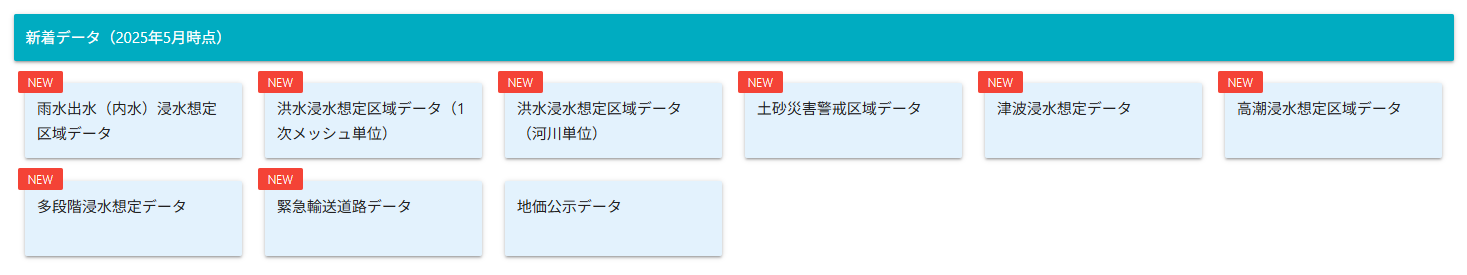

In [ ]:
# --- ライブラリのインポート ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from branca.colormap import linear

hazard_map_file = 'flood_hazard.geojson'

target = '人口（総数）'
#
# --- CSV読み込み ---
csv_path = '/content/mesh250.csv'
try:
    df = pd.read_csv(csv_path, skiprows=1, encoding='utf-8', dtype={'KEY_CODE': str})
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, skiprows=1, encoding='shift_jis', dtype={'KEY_CODE': str})

# --- 列名のクリーンアップ ---
df.columns = [col.strip().replace('\u3000', '') for col in df.columns]
df.rename(columns={df.columns[0]: 'KEY_CODE'}, inplace=True)
df[target] = pd.to_numeric(df[target], errors='coerce')
df.dropna(subset=['KEY_CODE', target], inplace=True)

# --- ポリゴン化 ---
df['geometry'] = df['KEY_CODE'].apply(meshcode_to_bbox_250m)
gdf_population = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# --- データの読み込み ---
city_gdf = gpd.read_file(output_geojson_path)
# --- ここから追加 ---
hazard_gdf = gpd.read_file(hazard_map_file) # 浸水想定区域のGeoJSON
# --------------------

# --- 【重要】座標参照系（CRS）の変換 ---
# 面積を正確に計算するため、すべての地理データをメートル単位の投影座標系に変換します
projected_crs = "EPSG:6680" # JGD2011 / Japan Plane Rectangular CS XII
gdf_population = gdf_population.to_crs(projected_crs)
city_gdf = city_gdf.to_crs(projected_crs)
hazard_gdf = hazard_gdf.to_crs(projected_crs) # 浸水区域も変換
# -------------------------------------
# --- 浸水想定区域を石狩市の範囲に限定 【ここを修正】 ---
print("浸水想定区域を石狩市の範囲にクリップ（切り出し）します...")
hazard_gdf = gpd.clip(hazard_gdf, city_gdf)
# ---------------------------------------------------
# --- 空間結合で石狩市内のメッシュだけ抽出 ---
# sjoinからclipに変更し、市境界でメッシュを正確に切り取ります
gdf_population['area_original'] = gdf_population.geometry.area # 元の面積を計算
gdf_filtered = gpd.clip(gdf_population, city_gdf)

# --- 石狩市内の総人口を面積按分で推定 ---
gdf_filtered['area_clipped'] = gdf_filtered.geometry.area
gdf_filtered['population_estimated'] = gdf_filtered[target] * (gdf_filtered['area_clipped'] / gdf_filtered['area_original'])
total_population_in_city = gdf_filtered['population_estimated'].sum()


# --- ここから被害予測の計算を追加 ---
print("被害予測の計算を開始します...")
# 石狩市内のメッシュとハザードマップが重なる部分を抽出
at_risk_intersected = gpd.overlay(gdf_filtered, hazard_gdf, how='intersection')

# 面積按分で浸水区域内の人口を推定
at_risk_intersected['area_at_risk'] = at_risk_intersected.geometry.area
at_risk_intersected['population_at_risk_estimated'] = at_risk_intersected[target] * (at_risk_intersected['area_at_risk'] / at_risk_intersected['area_original'])
at_risk_population_estimated = at_risk_intersected['population_at_risk_estimated'].sum()

# --- 結果の集計と表示 ---
print("\n--- 被害予測結果 ---")
print(f"石狩市内の推定総人口: {total_population_in_city:,.0f}人")
print(f"浸水リスク地域の推定人口: {at_risk_population_estimated:,.0f}人")
if total_population_in_city > 0:
    print(f"浸水リスク地域の人口割合: {at_risk_population_estimated / total_population_in_city:.2%}")
# -----------------------------

# --- 地図作成（Foliumは異なるCRSを扱えるため、再変換は不要） ---
center = [43.17, 141.31]
m = folium.Map(location=center, zoom_start=12)

# --- カラーマップ設定 ---
colormap = linear.YlOrRd_09.scale(
    gdf_filtered["population_estimated"].min(),
    gdf_filtered["population_estimated"].max()
)
colormap.caption = '推定人口数'
colormap.add_to(m)

# --- スタイル関数（ボーダーなし） ---
def style_function(feature):
    pop = feature['properties']['population_estimated']
    return {
        'fillColor': colormap(pop),
        'color': 'none',
        'weight': 0,
        'fillOpacity': 0.7
    }



# --- 浸水想定区域を地図に重ねて描画【ここから追加】 ---
folium.GeoJson(
    hazard_gdf,
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 0,
        'fillOpacity': 0.3 # 半透明にする
    },
    name='浸水想定区域'
).add_to(m)
# --- 人口メッシュの描画 ---
folium.GeoJson(
    gdf_filtered,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["KEY_CODE", "population_estimated"],
        aliases=["メッシュコード:", "推定人口:"],
        localize=True
    ),
    name='石狩市内500mメッシュ'
).add_to(m)
# ----------------------------------------------------

folium.LayerControl().add_to(m)

# --- 地図保存 ---
m.save('/content/ishikari_damage_prediction_map.html')
print("\n地図ファイル 'ishikari_damage_prediction_map.html' を保存しました。")
m